In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input, decode_predictions, ResNet50
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
import seaborn as sns

2024-04-12 10:51:01.037030: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 10:51:01.037159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 10:51:01.312018: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
my_data_dir='/kaggle/working/path/to/your'

In [3]:
import os
import shutil
import random

# Veri setinin bulunduğu dizin
data_dir = "/kaggle/input/flowers-recognition/flowers"

# Train ve test dizinlerini oluştur
train_dir = "path/to/your/train_data"
test_dir = "path/to/your/test_data"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Veri setindeki sınıflar
classes = os.listdir(data_dir)

# Train ve test oranı
train_ratio = 0.80

# Her sınıf için veri setini train ve test olarak ayır
for cls in classes:
    class_dir = os.path.join(data_dir, cls)
    images = os.listdir(class_dir)
    random.shuffle(images)
    train_size = int(len(images) * train_ratio)
    train_images = images[:train_size]
    test_images = images[train_size:]

    # Train ve test görüntülerini kopyala
    for img in train_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_dir, cls, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_dir, cls, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

print("Train-test split completed successfully.")

Train-test split completed successfully.


In [4]:
os.listdir(my_data_dir)

['test_data', 'train_data']

In [5]:
train_path = my_data_dir+'/train_data'
test_path = my_data_dir+'/test_data'

In [6]:
os.listdir(train_path)

['tulip', 'dandelion', 'sunflower', 'daisy', 'rose']

In [7]:
len(os.listdir(train_path+'/rose'))

627

In [8]:
len(os.listdir(train_path+'/tulip'))

787

In [9]:
os.listdir(train_path+'/rose')[:10]

['5628552852_60bbe8d9b0_n.jpg',
 '9164924345_6b63637acf.jpg',
 '5721768347_2ec4d2247b_n.jpg',
 '17158274118_00ec99a23c.jpg',
 '5693492187_dc46424be3_n.jpg',
 '3475572132_01ae28e834_n.jpg',
 '7376471712_e1be793f94.jpg',
 '10503217854_e66a804309.jpg',
 '12202373204_34fb07205b.jpg',
 '8524505682_bda885af3a_n.jpg']

In [10]:
os.listdir(train_path+'/tulip')[:10]

['16568530400_f7e4ffc633_n.jpg',
 '19759207480_679167eacd_n.jpg',
 '8713392604_90631fb809_n.jpg',
 '14078067903_92f5eb27ff.jpg',
 '4497976955_3f8c2a21c1_m.jpg',
 '3474066174_8d3b3e8f97_n.jpg',
 '14067761295_7cfe6a42e9.jpg',
 '5718512658_f3b1ec76d7_n.jpg',
 '21055041762_5d0a066948_n.jpg',
 '5738195260_b3fc107aa7_n.jpg']

In [13]:
path1=train_path+'/rose'+'/3475572132_01ae28e834_n.jpg'
path2=train_path+'/tulip'+'/4497976955_3f8c2a21c1_m.jpg'

In [14]:
rose_img=imread(path1)
tulip_img=imread(path2)

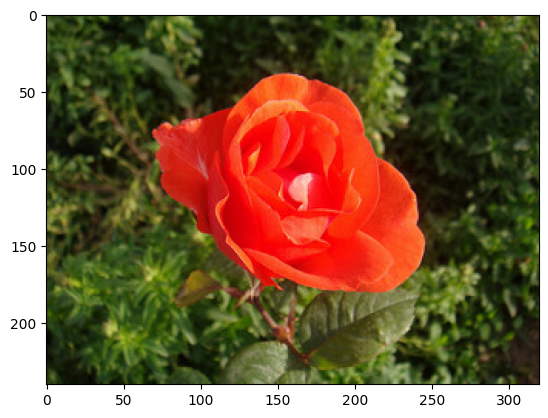

In [15]:
plt.imshow(rose_img);

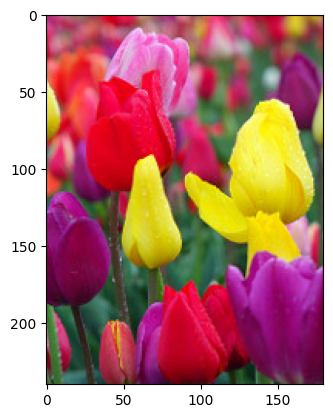

In [16]:
plt.imshow(tulip_img);

# **Data Augmentation**

In [17]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split = 0.3,
    rescale = 1/255
)

In [18]:
batch_size = 32
img_height = 256
img_width = 256

In [19]:
training_data = image_gen.flow_from_directory(
    train_dir,
    subset = "training",
    class_mode="categorical",
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False
)

validation_data = image_gen.flow_from_directory(
    train_dir,
    subset = "validation",
    class_mode="categorical",
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False
)

Found 2418 images belonging to 5 classes.
Found 1034 images belonging to 5 classes.


In [20]:
image_shape = (256,256,3)

# **CNN Model**

In [21]:
model = Sequential()

model.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
          
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 127, 127, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 62, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 30, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,368,645 (9.04 MB)

 Trainable params: 2,366,597 (9.03 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [22]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

results = model.fit(training_data,epochs=5,
                    validation_data=validation_data,
                    callbacks=[early_stop])

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1712919262.549468     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712919262.572662     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


71/76 ━━━━━━━━━━━━━━━━━━━━ 2s 535ms/step - accuracy: 0.1976 - loss: 1.8737

W0000 00:00:1712919333.025397     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 0.1979 - loss: 1.8626

W0000 00:00:1712919336.746705     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.1980 - loss: 1.8605 - val_accuracy: 0.2427 - val_loss: 1.6396
Epoch 2/5


W0000 00:00:1712919362.071687     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 61s 757ms/step - accuracy: 0.2048 - loss: 1.6187 - val_accuracy: 0.2437 - val_loss: 1.6202
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 61s 757ms/step - accuracy: 0.2127 - loss: 1.6073 - val_accuracy: 0.2253 - val_loss: 1.6106
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 62s 757ms/step - accuracy: 0.2331 - loss: 1.6122 - val_accuracy: 0.2485 - val_loss: 1.5893
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 61s 758ms/step - accuracy: 0.2049 - loss: 1.6247 - val_accuracy: 0.2437 - val_loss: 1.5920


In [23]:
summary = pd.DataFrame(model.history.history)
summary.head(15)

,accuracy,loss,val_accuracy,val_loss
0,0.204301,1.702492,0.242747,1.639648
1,0.206782,1.618192,0.243714,1.620231
2,0.224979,1.610206,0.225338,1.610591
3,0.213399,1.608171,0.248549,1.589296
4,0.238213,1.608273,0.243714,1.591953


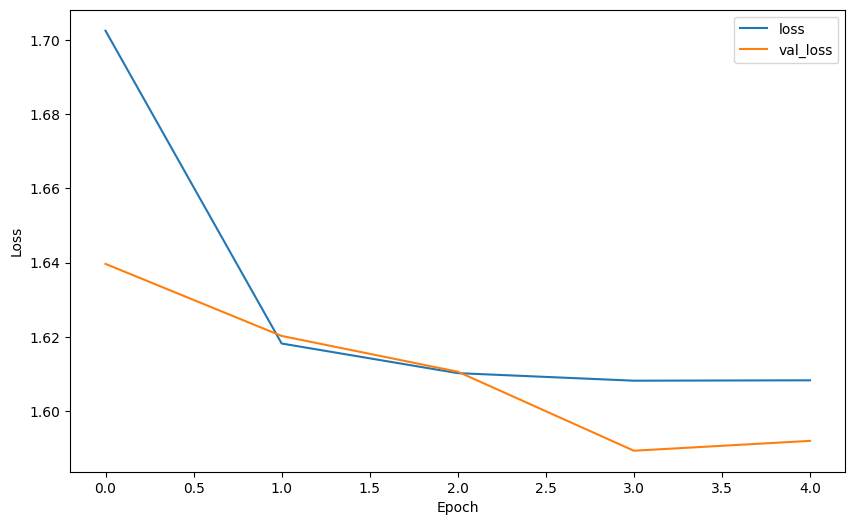

In [24]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

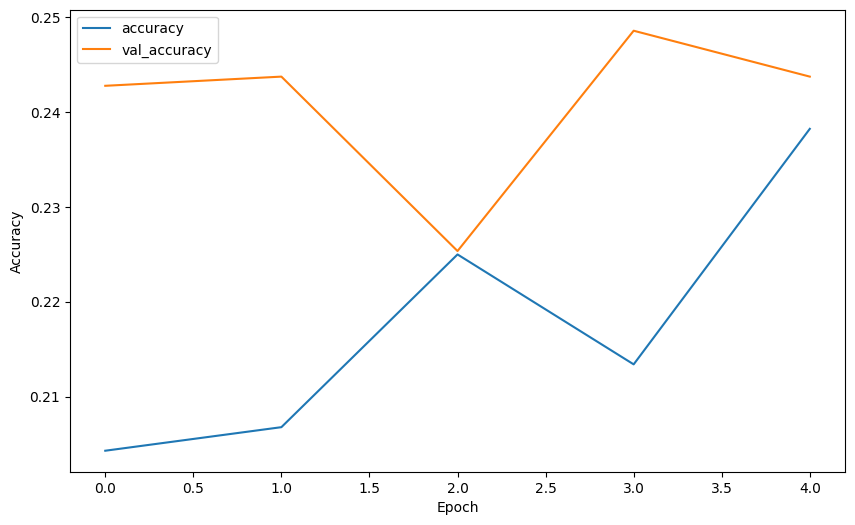

In [25]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [26]:
model.evaluate(training_data)
model.evaluate(validation_data)

76/76 ━━━━━━━━━━━━━━━━━━━━ 43s 558ms/step - accuracy: 0.3019 - loss: 1.6110


W0000 00:00:1712919741.893358     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 553ms/step - accuracy: 0.3022 - loss: 1.6120


[1.593860387802124, 0.24371373653411865]

In [27]:
pred_probabilities = model.predict(validation_data)
pred_probabilities

 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step

W0000 00:00:1712919837.180706     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 538ms/step


W0000 00:00:1712919854.383537     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([[0.1836476 , 0.25084922, 0.17482305, 0.1722222 , 0.21845792],
       [0.17960097, 0.26185   , 0.18020178, 0.16527489, 0.2130723 ],
       [0.17986064, 0.24963486, 0.17942376, 0.18037   , 0.21071075],
       ...,
       [0.16369076, 0.27608985, 0.18174726, 0.15939595, 0.21907625],
       [0.1875492 , 0.24201871, 0.16717887, 0.18722457, 0.21602863],
       [0.17375705, 0.26724502, 0.16908054, 0.16558583, 0.22433166]],
      dtype=float32)

In [28]:
validation_data.classes[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [29]:
predictions = pred_probabilities > 0.5

In [31]:
#print(classification_report(validation_data.classes,predictions))

# **Xception Model**

In [54]:
xception_model = Sequential()

pretrained_model= tf.keras.applications.Xception(include_top=False,
                   input_shape=image_shape,
                   pooling='avg',
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

xception_model.add(pretrained_model)
xception_model.add(Flatten())
xception_model.add(Dense(512, activation='relu'))
xception_model.add(Dense(512, activation='relu'))
xception_model.add(Dense(512, activation='relu'))
xception_model.add(Dense(5, activation='softmax'))
xception_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

xception_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [55]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)
results = xception_model.fit(training_data,epochs=25,
                    validation_data=validation_data,
                    callbacks=[early_stop])

Epoch 1/25
 1/76 ━━━━━━━━━━━━━━━━━━━━ 16:06 13s/step - accuracy: 0.3750 - loss: 1.4963

W0000 00:00:1712921179.722828     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/76 ━━━━━━━━━━━━━━━━━━━━ 25s 603ms/step - accuracy: 0.3489 - loss: 1.9729

W0000 00:00:1712921199.693107     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.3611 - loss: 1.7832

W0000 00:00:1712921223.886595     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 76s 836ms/step - accuracy: 0.3622 - loss: 1.7788 - val_accuracy: 0.5870 - val_loss: 1.1493
Epoch 2/25


W0000 00:00:1712921242.516737     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 62s 761ms/step - accuracy: 0.6046 - loss: 1.0034 - val_accuracy: 0.7660 - val_loss: 0.7274
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 61s 748ms/step - accuracy: 0.7468 - loss: 0.7125 - val_accuracy: 0.8085 - val_loss: 0.5102
Epoch 4/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 61s 753ms/step - accuracy: 0.8013 - loss: 0.5572 - val_accuracy: 0.7901 - val_loss: 0.5711
Epoch 5/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 62s 761ms/step - accuracy: 0.7808 - loss: 0.6092 - val_accuracy: 0.7485 - val_loss: 0.6790
Epoch 6/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 61s 757ms/step - accuracy: 0.8070 - loss: 0.5054 - val_accuracy: 0.8017 - val_loss: 0.5493
Epoch 7/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 62s 760ms/step - accuracy: 0.8520 - loss: 0.4044 - val_accuracy: 0.7631 - val_loss: 0.6092
Epoch 8/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 61s 760ms/step - accuracy: 0.8126 - loss: 0.5008 - val_accuracy: 0.8153 - val_loss: 0.5020
Epoch 9/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 61s 757ms/step - accuracy: 0.8871 - loss: 0.3116 - val_accuracy: 0.813

In [56]:
summary = pd.DataFrame(xception_model.history.history)
summary.head(15)

,accuracy,loss,val_accuracy,val_loss
0,0.441687,1.443334,0.587041,1.149326
1,0.662531,0.870647,0.765957,0.727391
2,0.755583,0.677011,0.808511,0.510204
3,0.784946,0.599476,0.790135,0.571101
4,0.803143,0.555856,0.748549,0.678997
5,0.815964,0.513187,0.801741,0.549280
6,0.843259,0.429194,0.763056,0.609155
7,0.837883,0.443163,0.815280,0.501951
8,0.881720,0.337291,0.813346,0.534789
9,0.873863,0.345916,0.838491,0.471568


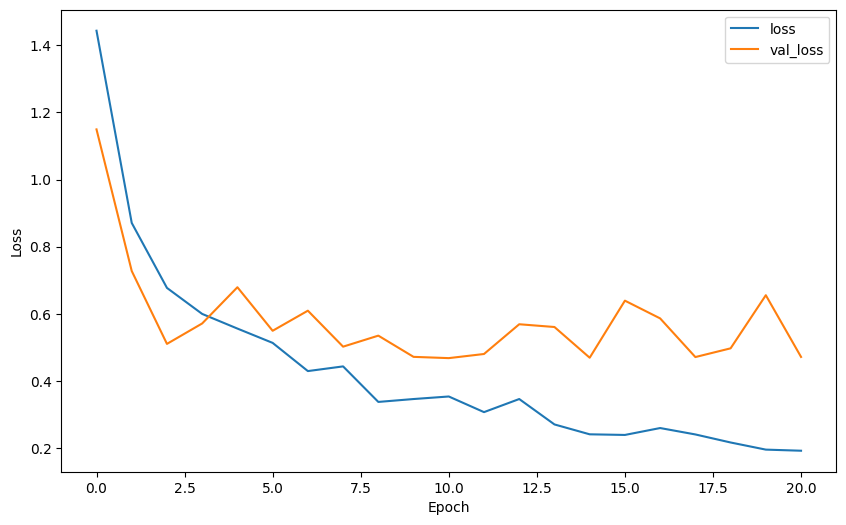

In [57]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

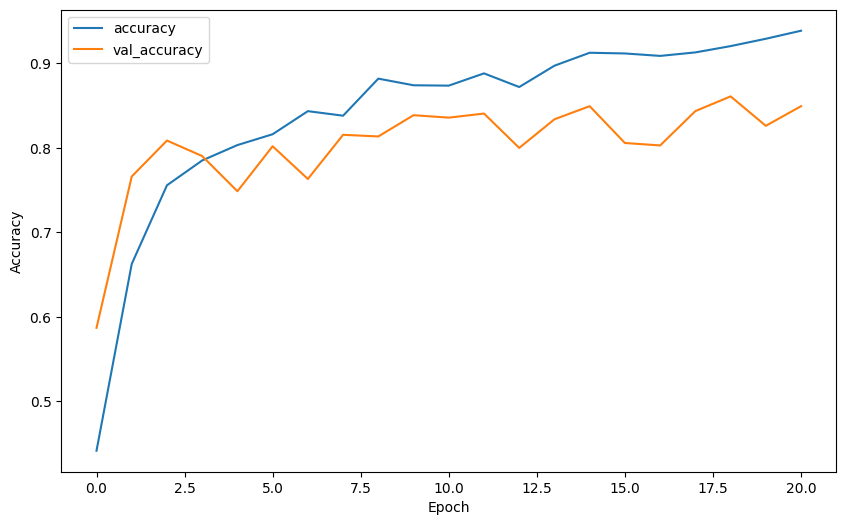

In [58]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [59]:
xception_model.evaluate(training_data)
xception_model.evaluate(validation_data)

76/76 ━━━━━━━━━━━━━━━━━━━━ 43s 567ms/step - accuracy: 0.9507 - loss: 0.1272


W0000 00:00:1712922666.971768     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 533ms/step - accuracy: 0.8863 - loss: 0.3280


[0.47624561190605164, 0.8375241756439209]

In [60]:
pred_probabilities = xception_model.predict(validation_data)
pred_probabilities

 2/33 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step

W0000 00:00:1712922707.894516     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 624ms/step


W0000 00:00:1712922727.874375     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([[9.9995196e-01, 1.4548477e-06, 3.1920583e-06, 1.2231055e-05,
        3.1061016e-05],
       [9.8136079e-01, 2.1113904e-06, 8.2350591e-05, 1.7937876e-06,
        1.8553052e-02],
       [9.9996340e-01, 2.6572812e-05, 7.8941503e-07, 1.3239417e-06,
        7.9177225e-06],
       ...,
       [1.1961857e-05, 2.6600910e-06, 8.9350756e-04, 8.1367779e-07,
        9.9909103e-01],
       [2.9271126e-01, 1.6534617e-02, 3.6141145e-01, 3.5308667e-02,
        2.9403397e-01],
       [4.3746721e-05, 3.0547704e-05, 3.9507020e-03, 3.6875270e-05,
        9.9593818e-01]], dtype=float32)

In [61]:
validation_data.classes[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [62]:
predictions = pred_probabilities > 0.5

In [79]:
#print(classification_report(validation_data.classes,predictions))

preds = xception_model.predict(validation_data)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

target_names = ['daisy','dandelion','rose','sunflower','tulip']
# Confusion matrix
cm = confusion_matrix(validation_data.classes, y_pred)
#plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(validation_data.classes, y_pred, target_names= target_names))

33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 513ms/step
[0 0 0 ... 4 0 4]
              precision    recall  f1-score   support

       daisy       0.79      0.93      0.85       183
   dandelion       0.90      0.85      0.88       252
        rose       0.79      0.72      0.75       188
   sunflower       0.83      0.93      0.88       175
       tulip       0.85      0.77      0.81       236

    accuracy                           0.84      1034
   macro avg       0.83      0.84      0.83      1034
weighted avg       0.84      0.84      0.83      1034



# **MobilNetV2 Model**

In [64]:
mobilenet_model = Sequential()
pretrained_model= tf.keras.applications.MobileNetV2(include_top=False,
                   input_shape=image_shape,
                   pooling='avg',
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobilenet_model.add(pretrained_model)
mobilenet_model.add(Flatten())
mobilenet_model.add(Dense(512, activation='relu'))
mobilenet_model.add(Dense(512, activation='relu'))
mobilenet_model.add(Dense(5, activation='softmax'))
mobilenet_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

mobilenet_model.summary()

/tmp/ipykernel_34/3061270787.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pretrained_model= tf.keras.applications.MobileNetV2(include_top=False,


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [65]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)
results = mobilenet_model.fit(training_data,epochs=25,
                    validation_data=validation_data,
                    callbacks=[early_stop])

Epoch 1/25
 2/76 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.0469 - loss: 2.5869  

W0000 00:00:1712923121.288976     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/76 ━━━━━━━━━━━━━━━━━━━━ 31s 563ms/step - accuracy: 0.2526 - loss: 2.6536

W0000 00:00:1712923131.916936     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.3890 - loss: 1.9580

W0000 00:00:1712923162.924807     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 71s 792ms/step - accuracy: 0.3916 - loss: 1.9449 - val_accuracy: 0.5812 - val_loss: 0.9646
Epoch 2/25


W0000 00:00:1712923180.699475     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 58s 721ms/step - accuracy: 0.6629 - loss: 0.8008 - val_accuracy: 0.6673 - val_loss: 0.8861
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 59s 732ms/step - accuracy: 0.7719 - loss: 0.5786 - val_accuracy: 0.7843 - val_loss: 0.5922
Epoch 4/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 59s 725ms/step - accuracy: 0.8347 - loss: 0.4733 - val_accuracy: 0.8104 - val_loss: 0.5225
Epoch 5/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 59s 725ms/step - accuracy: 0.8319 - loss: 0.4067 - val_accuracy: 0.8337 - val_loss: 0.4677
Epoch 6/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 58s 716ms/step - accuracy: 0.8700 - loss: 0.3768 - val_accuracy: 0.8443 - val_loss: 0.4460
Epoch 7/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 704ms/step - accuracy: 0.8675 - loss: 0.3453 - val_accuracy: 0.8182 - val_loss: 0.5164
Epoch 8/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 702ms/step - accuracy: 0.8760 - loss: 0.3455 - val_accuracy: 0.8172 - val_loss: 0.4885
Epoch 9/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 698ms/step - accuracy: 0.9185 - loss: 0.2494 - val_accuracy: 0.814

In [66]:
summary = pd.DataFrame(mobilenet_model.history.history)
summary.head(15)

,accuracy,loss,val_accuracy,val_loss
0,0.488420,1.453658,0.581238,0.964558
1,0.705542,0.726770,0.667311,0.886129
2,0.783706,0.568649,0.784333,0.592240
3,0.828784,0.473511,0.810445,0.522523
4,0.843259,0.416034,0.833656,0.467655
5,0.858561,0.392354,0.844294,0.446000
6,0.862283,0.373531,0.818182,0.516357
7,0.863937,0.370638,0.817215,0.488514
8,0.911911,0.252313,0.814313,0.542536
9,0.906121,0.252884,0.849130,0.449716


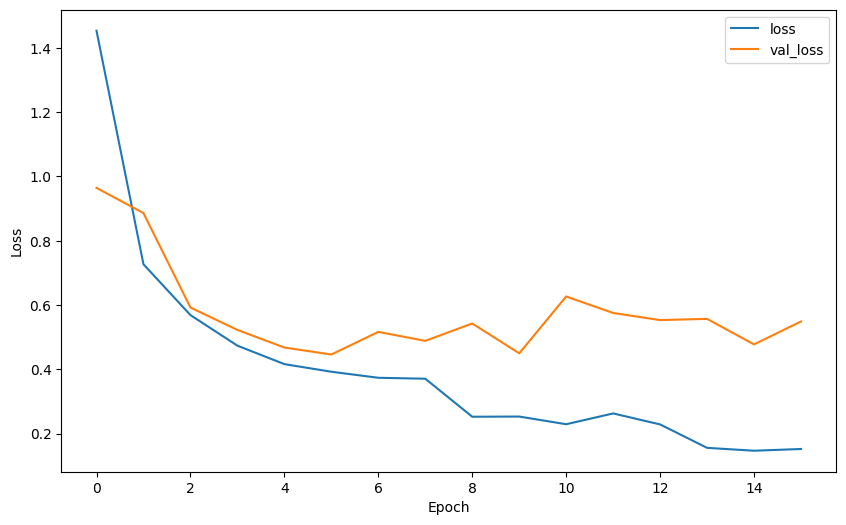

In [67]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

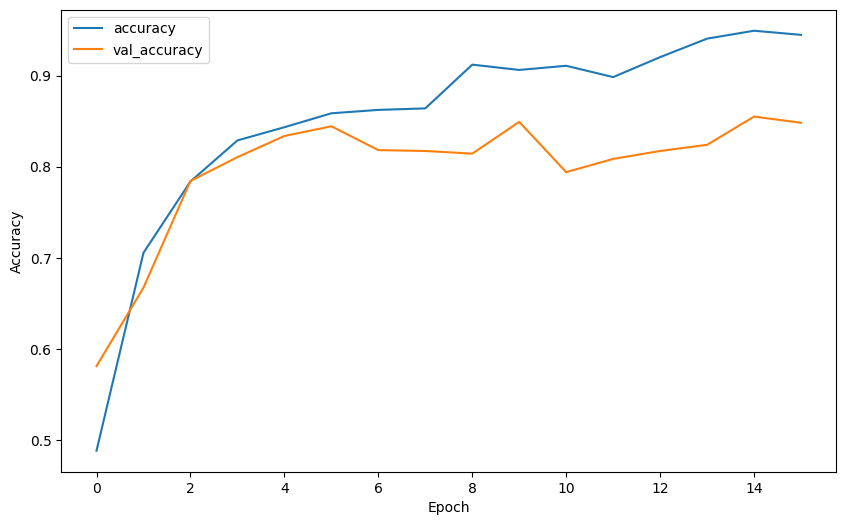

In [68]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [69]:
mobilenet_model.evaluate(training_data)
mobilenet_model.evaluate(validation_data)

76/76 ━━━━━━━━━━━━━━━━━━━━ 41s 540ms/step - accuracy: 0.9510 - loss: 0.1290


W0000 00:00:1712924377.862956     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 518ms/step - accuracy: 0.8825 - loss: 0.4283


[0.5790526270866394, 0.8423597812652588]

In [70]:
pred_probabilities = mobilenet_model.predict(validation_data)
pred_probabilities

 1/33 ━━━━━━━━━━━━━━━━━━━━ 1:54 4s/step

W0000 00:00:1712924409.138005     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 579ms/step


W0000 00:00:1712924427.662434     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([[9.9995792e-01, 2.5107211e-06, 1.0326320e-06, 9.3390363e-06,
        2.9214381e-05],
       [9.9929512e-01, 6.5287181e-06, 2.9893499e-06, 1.4413182e-04,
        5.5115408e-04],
       [9.9979198e-01, 9.7634766e-05, 1.5393863e-06, 1.0589798e-04,
        2.8959996e-06],
       ...,
       [2.3431436e-08, 9.5893493e-10, 7.7258328e-06, 4.6559883e-08,
        9.9999225e-01],
       [4.1846466e-01, 1.7464073e-02, 1.2489457e-01, 5.6194095e-03,
        4.3355736e-01],
       [3.3394410e-04, 3.2352746e-04, 1.1832895e-04, 5.4164248e-04,
        9.9868256e-01]], dtype=float32)

In [71]:
validation_data.classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [72]:
predictions = pred_probabilities > 0.5

In [73]:
validation_data.classes

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

In [78]:
#print(classification_report(validation_data.classes,predictions))

preds = mobilenet_model.predict(validation_data)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

target_names = ['daisy','dandelion','rose','sunflower','tulip']
# Confusion matrix
cm = confusion_matrix(validation_data.classes, y_pred)
#plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(validation_data.classes, y_pred, target_names= target_names))

33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 508ms/step
[0 0 0 ... 4 2 4]
              precision    recall  f1-score   support

       daisy       0.85      0.93      0.89       183
   dandelion       0.91      0.91      0.91       252
        rose       0.89      0.59      0.71       188
   sunflower       0.81      0.89      0.85       175
       tulip       0.76      0.85      0.80       236

    accuracy                           0.84      1034
   macro avg       0.84      0.83      0.83      1034
weighted avg       0.84      0.84      0.83      1034



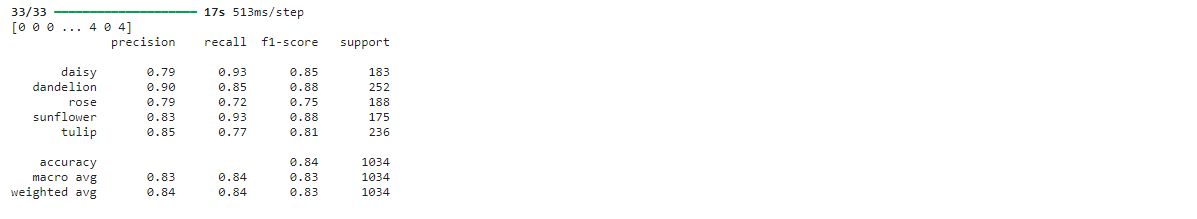